# Single Mode Frequency Domain Waveform Construction

By: Lorenzo Speri and Michael L. Katz

Here we provide the basic ideas of how to construct a Frequency Domain EMRI Waveform for a single harmonic. Note that in this noteboook only the monotonic modes can be calculated. The full frequency domain waveform is build from performing a method similar to what is presented here for each harmonic with some adjustments for harmonics with turnover in the time-frequency relation. 

In [1]:
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from few.amplitude.romannet import RomanAmplitude
from few.waveform import FastSchwarzschildEccentricFlux
from few.utils.utility import get_fundamental_frequencies
from few.utils.ylm import GetYlms
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.utils.constants import *
from few.trajectory.inspiral import EMRIInspiral

traj = EMRIInspiral(func="SchwarzEccFlux")

In [2]:
use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

ylm_gen = GetYlms(assume_positive_m=True, use_gpu=False)

## Trajectory and amplitudes

In [3]:
# set the mode to compute
l_sel = 2
m_sel = 2
n_sel = 0
specific_modes = [(l_sel, m_sel, n_sel)]

# parameters
M = 1e6
mu = 5e1
p0 = 10.0
e0 = 0.4
theta = np.pi/4.
phi = np.pi/3.

dist =1
dt =10.
T = 1.0#/12

# evolve trajectory
t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, mu, 0.0, p0, e0, 1.0, T=T)

# get amplitudes along trajectory
amp = RomanAmplitude()

teuk_modes = amp(p, e, specific_modes=specific_modes)

# get ylms
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

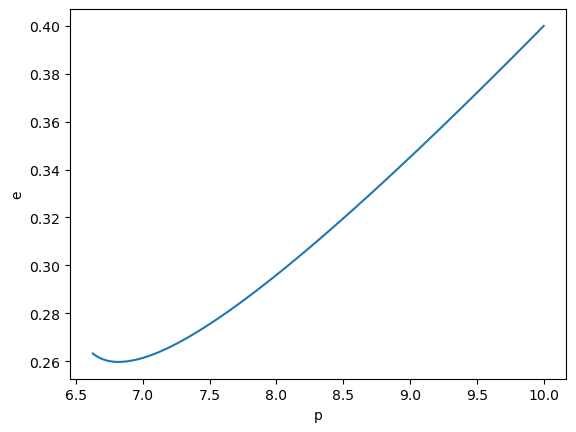

In [4]:
# plot p-e trajectory
plt.figure()
plt.plot(p,e)
plt.xlabel('p')
plt.ylabel('e')
plt.show()

## Spline phase evolution

In [5]:
# phase evolution of the harmonic
phase_evolution = m_sel*Phi_phi + n_sel*Phi_r

# spline the phase evolutions
interp_in = phase_evolution
spline = CubicSplineInterpolant(t, interp_in)
phase_spline = spline

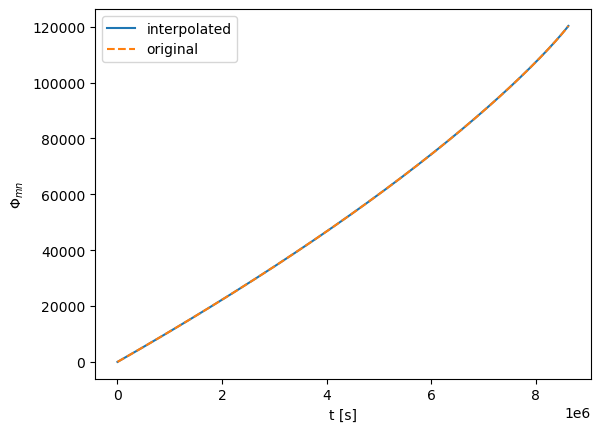

In [6]:
# get new values
t_new = np.linspace(t[0], t[-1], 1000)

# notice the new shape is (ninterps, length) just like the inital input to the spline
new_phase_evolution = spline(t_new)

plt.plot(t_new, new_phase_evolution, label='interpolated')
plt.plot(t, phase_evolution, '--', label='original')
plt.legend()
plt.xlabel('t [s]')
plt.ylabel(r'$\Phi_{mn}$')
plt.show()

## Spline derivative of the phase

In [7]:
from scipy.interpolate import CubicSpline
scipy_spline = CubicSpline(t, interp_in)
deriv_spline = scipy_spline.derivative()
OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(0.0, p, e, 0.0)

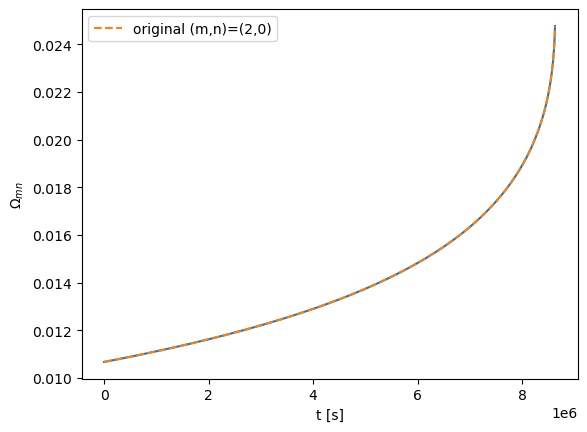

In [8]:
plt.plot(t, deriv_spline(t))
plt.plot(t, (m_sel*OmegaPhi + n_sel*OmegaR)/(M*MTSUN_SI), '--', label='original (m,n)='+'(' +str(m_sel)+','+str(n_sel)+')' )
plt.legend()
plt.xlabel('t [s]')
plt.ylabel(r'$\Omega_{mn}$')
plt.show()

## Find the time-frequency correspondence $t(f)$

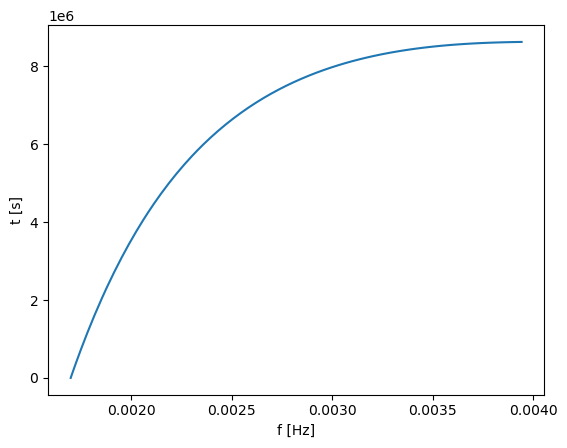

In [9]:
# frequency evolution
theo_f = (m_sel*OmegaPhi + n_sel*OmegaR)/(2*np.pi*M*MTSUN_SI)

# spline to get time frequency map
time_f_spline = CubicSpline(theo_f,t)

plt.figure()
plt.plot(theo_f,time_f_spline(theo_f))
plt.ylabel('t [s]')
plt.xlabel('f [Hz]')
plt.show()

In [10]:
print('frequency range',np.min(theo_f), np.max(theo_f))

frequency range 0.0016982910091182908 0.003941734545312092


## Obtain $\dot{F}(t)$

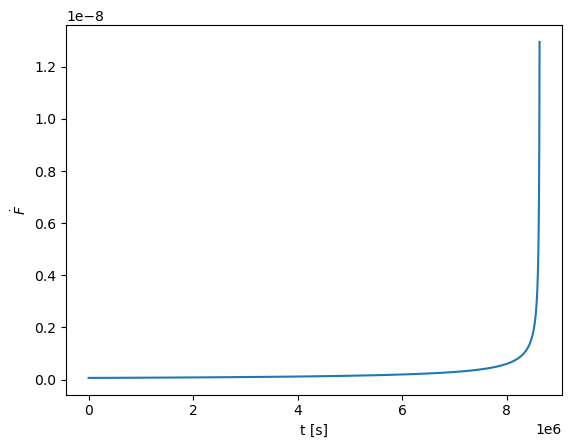

In [11]:
fdot_spline = CubicSpline(t,theo_f).derivative()
plt.plot(t,fdot_spline(t))
plt.xlabel('t [s]')
plt.ylabel('$\dot F$')
plt.show()

## Amplitude H

In [12]:
# check shape teukolsky amplitudes
print(np.shape(teuk_modes[(l_sel, m_sel, n_sel)]))

# get the amplitudes for given mode
true_teuk = teuk_modes[(l_sel, m_sel, n_sel)]

(86,)


In [13]:
interp_teuk = np.zeros((2,true_teuk.shape[0]))

# split in real and imaginary
interp_teuk[0,:] = true_teuk.T.real
interp_teuk[1,:] = true_teuk.T.imag

teuk_spline = CubicSplineInterpolant(t, interp_teuk)
H_spline=teuk_spline

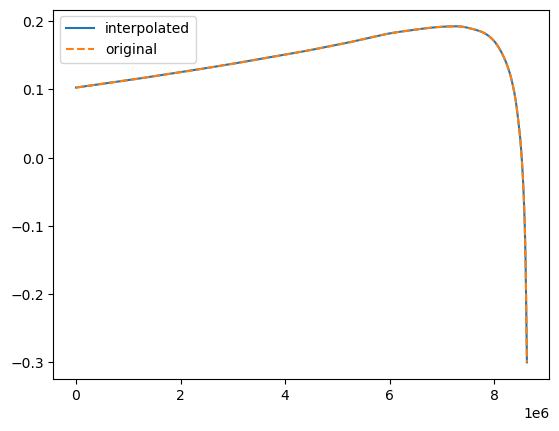

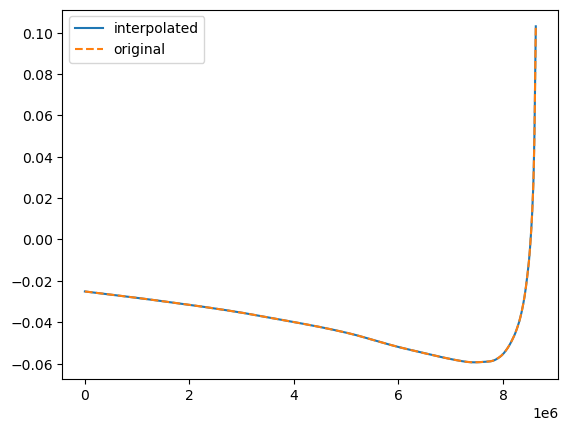

In [14]:
# get new values
t_new = np.linspace(t[0], t[-1], 1000)

# notice the new shape is (ninterps, length) just like the inital input to the spline
new_teuk_modes = teuk_spline(t_new)

plt.figure()
plt.plot(t_new, new_teuk_modes[0], label='interpolated')
plt.plot(t, np.real(true_teuk), '--', label='original')
plt.legend()

plt.figure()
plt.plot(t_new, new_teuk_modes[1], label='interpolated')
plt.plot(t, np.imag(true_teuk), '--', label='original')
plt.legend()

## Obtain FD waveform for one harmonic from $\Phi(t(f))$, $H(t(f))$, $\dot{F}(t(f))$

In [15]:
# set frequency input
f = np.linspace(np.min(theo_f),np.max(theo_f),1000)

# get total amplitude
Amp1 = (H_spline(time_f_spline(f))[0] + 1j* H_spline(time_f_spline(f))[1])*ylm_gen(np.array([l_sel]), np.array([m_sel]), theta, phi)[0]

fd_h1 = Amp1 *\
        np.exp(-1j*(2 * np.pi * f* time_f_spline(f)  - 
        phase_spline(time_f_spline(f) ) + np.pi/4) ) / \
        np.sqrt(fdot_spline(time_f_spline(f)))

fd_h = fd_h1
fd_h = fd_h * 1.0 / ((dist * Gpc) / (mu * MRSUN_SI))


(0.0016982910091182908, 0.003941734545312092)

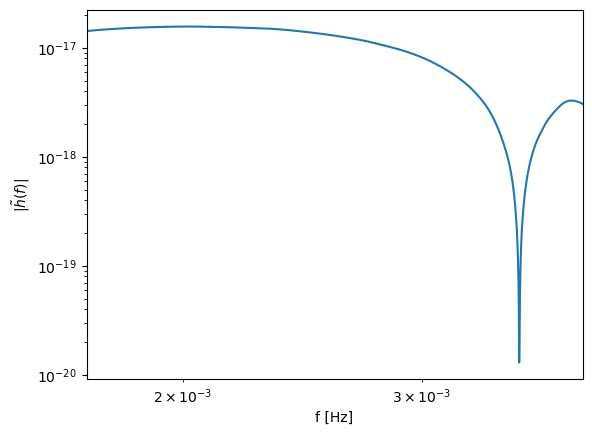

In [16]:
plt.ylabel(r'$|\tilde{h}(f)|$')
plt.xlabel('f [Hz]')
plt.loglog(f,np.abs(fd_h))
plt.xlim(np.min(theo_f),np.max(theo_f))

## Time vs Frequency Domain
Here we compare the Frequency Domain waveform and compare it against the FFT of the time domain waveform. The agreement is quite good but we need to change some signs due to the FFT conventions. Try out different parameters and modes :)

In [17]:
from scipy import special

l_sel = 2
m_sel = 2
n_sel = 0

specific_modes = [(l_sel, m_sel, n_sel)]

# get amplitudes along trajectory
amp = RomanAmplitude()

# parameters
M = 1e6
mu = 5e1
p0 = 10.0
e0 = 0.4
theta = np.pi/4.
phi = np.pi/3.

dist =1
dt =10.
T = 2.0

# TIME DOMAIN
few_base = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

wave_22 = few_base(M, mu, p0, e0, theta, phi, dist=dist, dt=dt, T=T, mode_selection=specific_modes)

freq_fft = np.fft.fftfreq(len(wave_22),dt)
fft_wave = np.fft.fft(wave_22)*dt

# FREQ DOMAIN

def FD_waveform(freq):

    t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, mu, 0.0, p0, e0, 1.0, T=T)
    teuk_modes = amp(p, e,specific_modes=specific_modes)
    
    # Phi_mn (t)
    phase_evolution = m_sel*Phi_phi + n_sel*Phi_r
    phase_spline = CubicSplineInterpolant(t, phase_evolution)

    OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(0.0, p, e, 0.0)
    
    # t(f)
    theo_f = (m_sel*OmegaPhi + n_sel*OmegaR)/(2*np.pi*M*MTSUN_SI)
    
    time_f_spline_0 = CubicSpline(theo_f,t)
    
    # frequency
    index_positive_f = (freq>np.min(theo_f))*(freq<np.max(theo_f))
    index_negative_f = (freq>np.min(-theo_f))*(freq<np.max(-theo_f))
    f_0 = freq[index_positive_f]
    f_1 = freq[index_negative_f]
    
    # time evluated quantities
    t_f_0 = time_f_spline_0(f_0)
    t_f_1 = np.flip(t_f_0)
    
    # Fdot
    fdot_spline_0 = CubicSpline(t,theo_f).derivative()
    fdot_spline_1 = CubicSpline(t,-theo_f).derivative()
    
    # Fddot
    fdd_0 = CubicSpline(t,fdot_spline_0(t)).derivative()
    fdd_1 = CubicSpline(t,fdot_spline_1(t)).derivative()
    
    # amplitude
    np.shape(teuk_modes[(l_sel, m_sel, n_sel)])
    true_teuk = teuk_modes[(l_sel, m_sel, n_sel)]
    interp_teuk = np.zeros((2,true_teuk.shape[0]))

    interp_teuk[0,:] = true_teuk.T.real
    interp_teuk[1,:] = true_teuk.T.imag

    H_spline = CubicSplineInterpolant(t, interp_teuk)
    
    # spherical harmonics
    ylms = ylm_gen(np.array([l_sel]), np.array([m_sel]), theta, phi)
    
    arg_0 = -2*np.pi*1j* fdot_spline_0(t_f_0)**3 / (3*fdd_0(t_f_0)**2)
    K_1over3_0 = special.kv(1./3.,arg_0)*np.exp(arg_0) 
    
    arg_1 = -2*np.pi*1j* fdot_spline_1(t_f_1)**3 / (3*fdd_1(t_f_1)**2)
    K_1over3_1 = special.kv(1./3.,arg_1)*np.exp(arg_1) 
    
    #print(K_1over3)
                                                  
    Amp0 = (H_spline(t_f_0)[0] + 1j* H_spline(t_f_0)[1])*ylms[0] \
            *1j* fdot_spline_0(t_f_0)/np.abs(fdd_0(t_f_0)) \
            * K_1over3_0 * 2/np.sqrt(3)
    
    Amp1 = (H_spline(t_f_1)[0] - 1j* H_spline(t_f_1)[1])*ylms[1]\
            *1j* fdot_spline_1(t_f_1)/np.abs(fdd_1(t_f_1)) \
            * K_1over3_1 * 2/np.sqrt(3)
        
    Exp0 = np.exp(1j*(2*np.pi*f_0* t_f_0  - phase_spline(t_f_0)) )
    Exp1 = np.exp(1j*(2*np.pi*f_1* t_f_1  + phase_spline(t_f_1)) )

    # final waveform
    h = np.zeros_like(freq,dtype=complex) 
    h[index_positive_f] = Amp0*Exp0
    h[index_negative_f] = Amp1*Exp1
    
    return h / ((dist * Gpc) / (mu * MRSUN_SI))

fd_h = FD_waveform(freq_fft)


Compare amplitudes

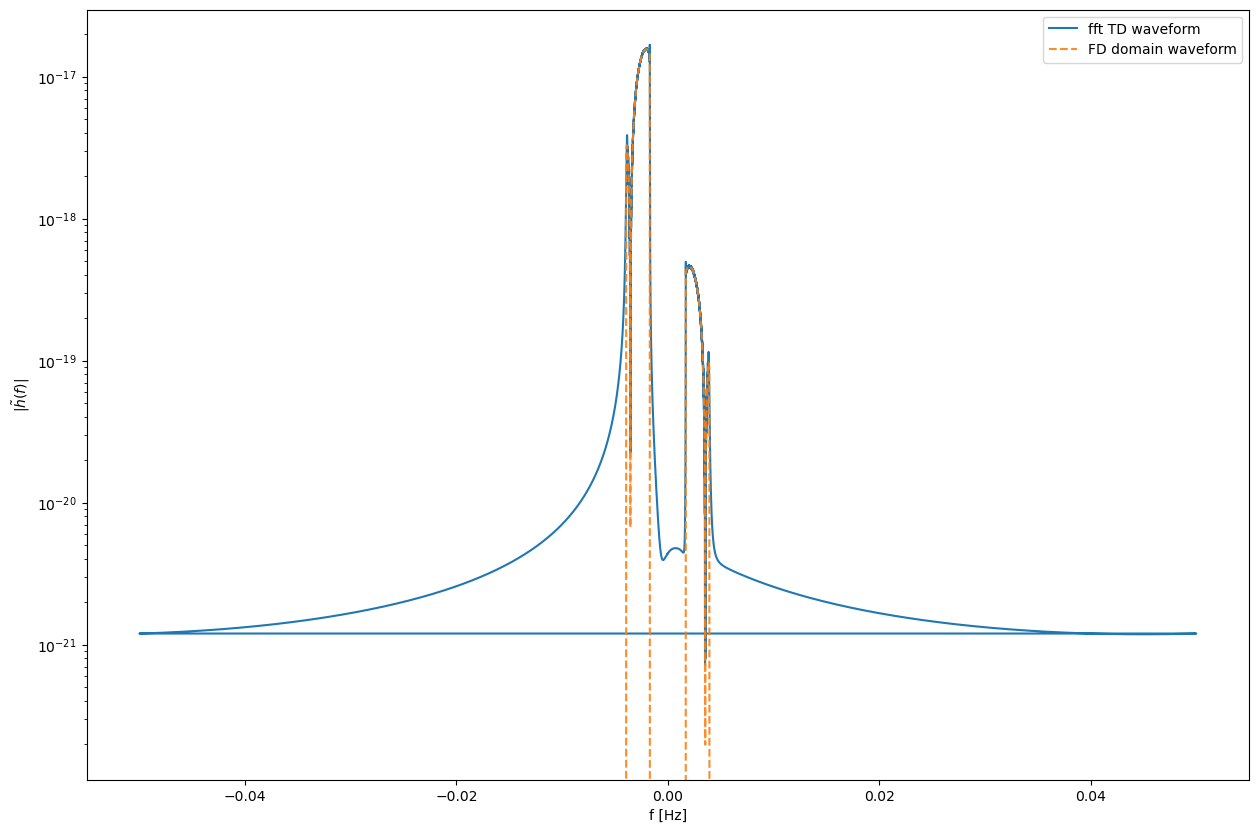

In [18]:
# plot
plt.figure(figsize=(15,10))
plt.ylabel(r'$|\tilde{h}(f)|$')
plt.xlabel('f [Hz]')
plt.semilogy(freq_fft, np.abs(fft_wave), label='fft TD waveform')

# FD model
plt.semilogy(-freq_fft,np.abs(fd_h),'--',alpha=0.9,label='FD domain waveform' )

plt.legend()
#plt.xlim(0.5e-3,5e-3)
plt.show()

Real part

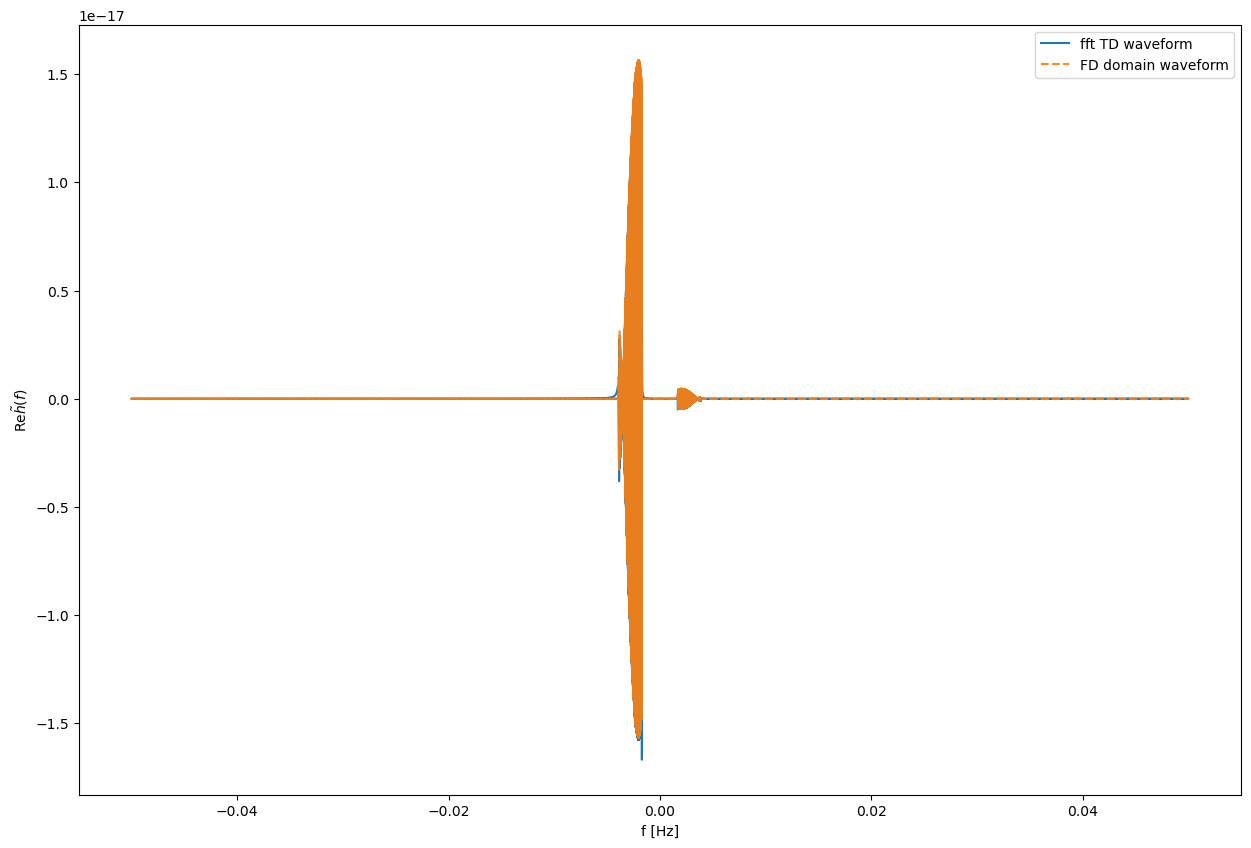

In [19]:
Nhalf = int(len(freq_fft)/2)

plt.figure(figsize=(15,10))
plt.ylabel(r'Re$\tilde{h}(f)$')
plt.xlabel('f [Hz]')
plt.plot(freq_fft, np.real(fft_wave), label='fft TD waveform')

# FD model
plt.plot(-freq_fft,-np.real(fd_h),'--',alpha=0.9,label='FD domain waveform' )

plt.legend()
plt.show()


Imaginary part

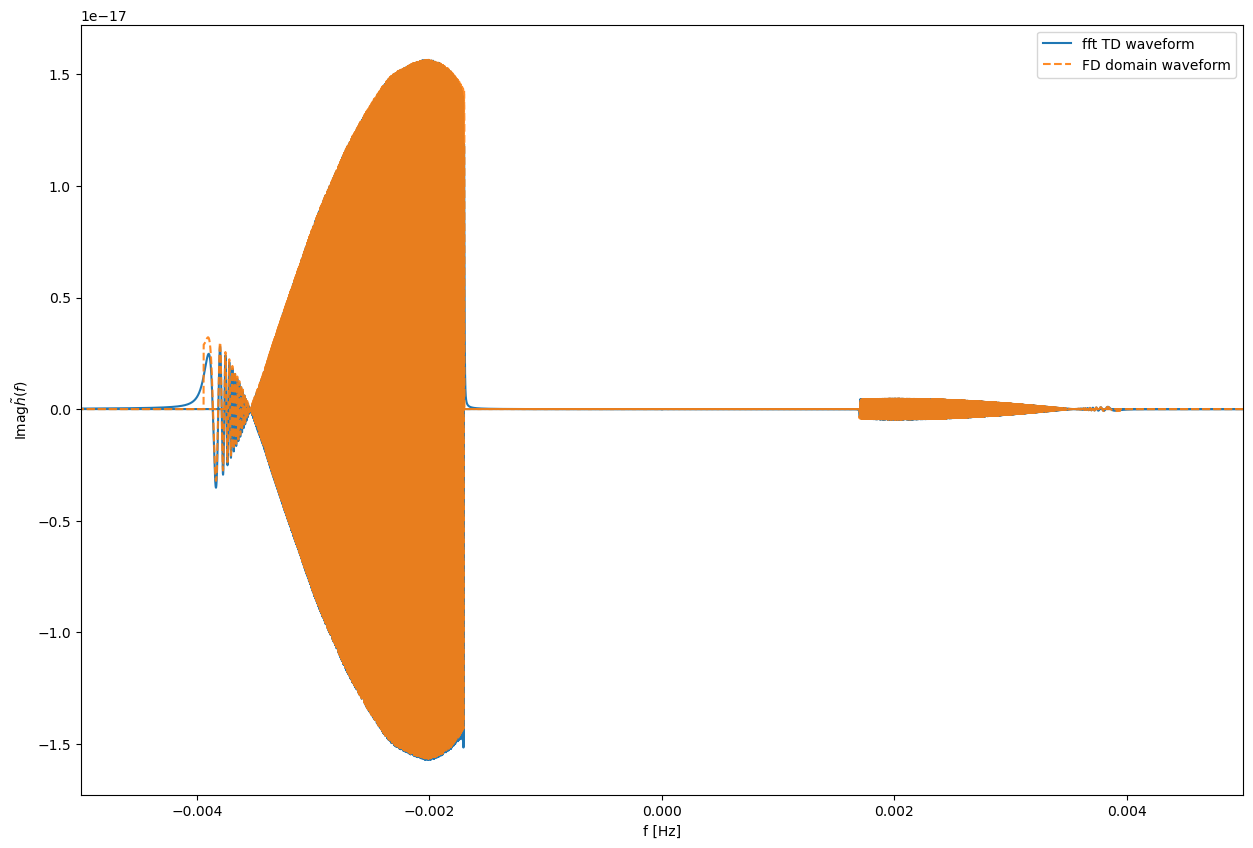

In [20]:
# plot
plt.figure(figsize=(15,10))
plt.ylabel(r'Imag$\tilde{h}(f)$')
plt.xlabel('f [Hz]')
plt.plot(freq_fft, np.imag(fft_wave), label='fft TD waveform')

# FD model
plt.plot(-freq_fft,-np.imag(fd_h),'--',alpha=0.9,label='FD domain waveform' )

plt.legend()
plt.xlim(-5e-3,5e-3)
plt.show()
